# IMDB Algorithms:

In [1]:
import pandas as pd
import numpy as np
import sys
import re
import scikitplot as skplt
import math
import nltk
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn import neighbors
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
count=CountVectorizer()

import string
import math
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, accuracy_score, roc_auc_score, roc_curve
from sklearn.model_selection import GridSearchCV

In [2]:
imdb_review = pd.read_csv('movie_review_info_full1.csv', sep = ';')
imdb_review.head()

,userId,reviewDate,userReview,movieId,class
0,80735290,26-11月-21,That's all this really is to me. A Loveletter ...,15005868,1.0
1,139254098,25-11月-21,Trey and Matt show once again that they can co...,15005868,1.0
2,118562022,25-11月-21,"If you're a fan of South Park, you'll love thi...",15005868,1.0
3,548970,25-11月-21,It's fun seeing the boys all grown up. Yeah th...,15005868,1.0
4,23053711,25-11月-21,South Park has always been great at poking hol...,15005868,1.0


In [3]:
np.shape(imdb_review)

(4169, 5)

In [4]:
imdb_review["class"].value_counts()

1.0     2151
0.0     2016
11.0       1
Name: class, dtype: int64

In [5]:
# Remove 11, NaN in "class":
imdb_review["class"] = imdb_review["class"].replace([11.0], [1])
Total_class = imdb_review['class'].tolist()
Total_class = list(map(lambda x: 0.0 if math.isnan(x) else x, Total_class))

imdb_review["class"] = Total_class

In [6]:
imdb_review.head()

,userId,reviewDate,userReview,movieId,class
0,80735290,26-11月-21,That's all this really is to me. A Loveletter ...,15005868,1.0
1,139254098,25-11月-21,Trey and Matt show once again that they can co...,15005868,1.0
2,118562022,25-11月-21,"If you're a fan of South Park, you'll love thi...",15005868,1.0
3,548970,25-11月-21,It's fun seeing the boys all grown up. Yeah th...,15005868,1.0
4,23053711,25-11月-21,South Park has always been great at poking hol...,15005868,1.0


In [7]:
userReview = imdb_review['userReview']
type(userReview[0])

str

In [15]:
# Partation of training and testing set:
# randomly split your data to train and test data
X_train, X_test, y_train, y_test = train_test_split(imdb_review['userReview'], class_test, stratify = class_test)

In [68]:
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import confusion_matrix, roc_auc_score
def print_score(clf, X_train, X_test, y_train, y_test, train=True):
    '''
    v0.1 Follow the scikit learn library format in terms of input
    print the accuracy score, classification report and confusion matrix of classifier
    '''
    lb = preprocessing.LabelBinarizer()
    lb.fit(y_train)
    if train:
        '''
        training performance
        '''
        res = clf.predict(X_train)
        print("Train Result:\n")
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_train, 
                                                                res)))
        print("Classification Report: \n {}\n".format(classification_report(y_train, 
                                                                            res)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_train, 
                                                                  res)))
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_train), 
                                                      lb.transform(res))))

#        res = cross_val_score(clf, X_train, y_train, cv=10, scoring='accuracy')
#        print("Average Accuracy: \t {0:.4f}".format(np.mean(res)))
#        print("Accuracy SD: \t\t {0:.4f}".format(np.std(res)))
        
    elif train==False:
        '''
        test performance
        '''
        res_test = clf.predict(X_test)
        print("Test Result:\n")        
        print("accuracy score: {0:.4f}\n".format(accuracy_score(y_test, 
                                                                res_test)))
        print("Classification Report: \n {}\n".format(classification_report(y_test, 
                                                                            res_test)))
        print("Confusion Matrix: \n {}\n".format(confusion_matrix(y_test, 
                                                                  res_test)))   
        print("ROC AUC: {0:.4f}\n".format(roc_auc_score(lb.transform(y_test), 
                                                      lb.transform(res_test))))

# Method 1: Sentiment Analysis -- Lexicon Method

In [9]:
## Segmentation with blank
def segment_content(content):
    tokens = re.split('[ ;.?|:!,"")('']', content)#,.\|\?;:
    processed_tokens = []
    for token in tokens:
        if token != '':
            #print token
            processed_tokens.append(token)
    return processed_tokens

In [10]:
## Calculate sentiments
## Sentiment score of a review =
# (No. of positive words - No. of negative words) / (No. of positive words + No. of negative words)
senti_file = open('senti_lexicon.tff', 'r')  # sys.argv[0] - file path and name of sentiment lexicon
line = senti_file.readline().strip()
neg_lists = []
pos_lists = []
while line:
    attributes = line.split(' ')
    att_nums = len(attributes)
    word = attributes[2].split('=')[1]
    word_polarity = attributes[att_nums - 1].split('=')[1]
    if word_polarity == 'negative' or word_polarity == 'both':
        if word not in neg_lists:
            neg_lists.append(word)
    if word_polarity == 'positive' or word_polarity == 'both':
        if word not in pos_lists:
            pos_lists.append(word)
    line = senti_file.readline().strip()
senti_file.close()

In [11]:
TotalSS = []
for b in range(4169):
    SingleReview = userReview[b].strip().lower()
    ## Calculate sentiments
    ## Sentiment score of a review =
    # (No. of positive words - No. of negative words) / (No. of positive words + No. of negative words)    
    neg_nums = 0
    pos_nums = 0
    neg_words = []
    pos_words = []
    
    tokens = segment_content(SingleReview)  # sys.argv[0] - file path and name of review
    for token in tokens:
        if token in neg_lists:
            neg_words.append(token)
            neg_nums += 1
        if token in pos_lists:
            pos_words.append(token)
            pos_nums += 1
          
    if pos_nums == 0 and neg_nums == 0:
        sentimentScore = 0
    else:
        sentimentScore = float(pos_nums - neg_nums) / float(pos_nums + neg_nums)
    TotalSS.append(sentimentScore)

In [12]:
SentimentResult = []
for c in range(4169):
    if TotalSS[c] > 0:
        SR = 1
    else:
        SR = 0
    SentimentResult.append(SR)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

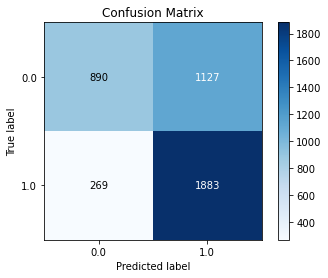

In [13]:
class_predict = SentimentResult
class_test = imdb_review["class"]

# Confusion Matrix:
skplt.metrics.plot_confusion_matrix(class_test, class_predict)

In [14]:
print("Score:",round(accuracy_score(class_test, class_predict)*100,2))
print("Classification Report:",classification_report(class_test, class_predict))

Score: 66.51
Classification Report:               precision    recall  f1-score   support

         0.0       0.77      0.44      0.56      2017
         1.0       0.63      0.88      0.73      2152

    accuracy                           0.67      4169
   macro avg       0.70      0.66      0.65      4169
weighted avg       0.69      0.67      0.65      4169



# Method 2: KNN:

In [21]:
# Build TFIDF vectors based on training tweets
training_labels = y_train
training_features = X_train.values
# max_df=0.5: ingnore terms with document frequency higher than the given threshold
count_vec1 = CountVectorizer(stop_words = 'english', max_df = 0.5, decode_error = 'ignore')
counts_train = count_vec1.fit_transform(training_features)
tfidftransformer = TfidfTransformer()
tfidf_train = tfidftransformer.fit(counts_train).transform(counts_train)

In [22]:
# Build TFIDF vectors based on testing tweets
validation_labels = y_test
validation_features = X_test.values
count_vec2 = CountVectorizer(vocabulary = count_vec1.vocabulary_, stop_words = 'english', max_df = 0.5, decode_error = 'ignore')
counts_valid = count_vec2.fit_transform(validation_features)
tfidf_valid = tfidftransformer.fit(counts_valid).transform(counts_valid)

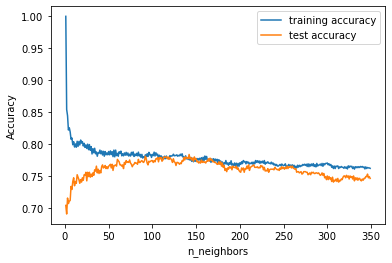

In [25]:
# next we will try KNN classification with different K 
# initialize vectors to save results, in sample and out of sample accuracy
training_accuracy = [] 
test_accuracy = []

# try n_neighbors from 1 to 10 neighbors_settings = range(1, 11)
neighbors_settings = range(1, 350)

for n_neighbors in neighbors_settings:
    # build the model
    clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors) 
    clf.fit(tfidf_train, training_labels)
    # record training set accuracy 
    training_accuracy.append(clf.score(tfidf_train, training_labels)) 
    # record generalization accuracy 
    test_accuracy.append(clf.score(tfidf_valid, validation_labels))

plt.plot(neighbors_settings, training_accuracy, label="training accuracy")
plt.plot(neighbors_settings, test_accuracy, label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()

In [26]:
test_accuracy.index(max(test_accuracy))+1

142

In [71]:
# Use KNN to classify the texts of validation set
knn = neighbors.KNeighborsClassifier(n_neighbors = 142)
knn.fit(tfidf_train, training_labels)
predict_results = knn.predict(tfidf_valid)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

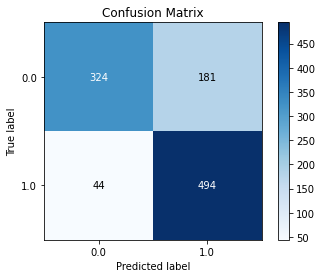

In [72]:
# Confusion Matrix:
skplt.metrics.plot_confusion_matrix(validation_labels, predict_results)

In [81]:
#print("Score:",round(accuracy_score(validation_labels, predict_results)*100,2))
#print("Classification Report:",classification_report(validation_labels, predict_results))

In [74]:
print_score(knn, tfidf_train, tfidf_valid, training_labels, validation_labels, train=True)
print("\n******************************\n")
print_score(knn, tfidf_train, tfidf_valid, training_labels, validation_labels, train=False)

Train Result:

accuracy score: 0.7799

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.86      0.65      0.74      1512
         1.0       0.73      0.90      0.81      1614

    accuracy                           0.78      3126
   macro avg       0.80      0.78      0.77      3126
weighted avg       0.80      0.78      0.78      3126


Confusion Matrix: 
 [[ 978  534]
 [ 154 1460]]

ROC AUC: 0.7757


******************************

Test Result:

accuracy score: 0.7843

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.88      0.64      0.74       505
         1.0       0.73      0.92      0.81       538

    accuracy                           0.78      1043
   macro avg       0.81      0.78      0.78      1043
weighted avg       0.80      0.78      0.78      1043


Confusion Matrix: 
 [[324 181]
 [ 44 494]]

ROC AUC: 0.7799



# Method 3: Random Forest:

In [36]:
from sklearn.ensemble import RandomForestClassifier

In [41]:
# Grid Search:
rmfr = RandomForestClassifier(random_state=2022)
params_grid = {"max_samples": [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
               "max_features": [1,2,3,4,5,6,7,8]}
#               "max_depth": [3, None],
#               "min_samples_split": [2, 3, 10],
#               "min_samples_leaf": [1, 3, 10],
#               "bootstrap": [True, False],
#               "criterion": ['gini', 'entropy']}

In [42]:
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(rmfr, params_grid,
                           n_jobs=-1, cv=5,
                           verbose=1, scoring='accuracy')

grid_search.fit(tfidf_train, training_labels)

Fitting 5 folds for each of 72 candidates, totalling 360 fits


GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=2022),
             n_jobs=-1,
             param_grid={'max_features': [1, 2, 3, 4, 5, 6, 7, 8],
                         'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8,
                                         0.9]},
             scoring='accuracy', verbose=1)

In [43]:
grid_search.best_score_

0.7859905431309905

In [44]:
grid_search.best_estimator_.get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 7,
 'max_leaf_nodes': None,
 'max_samples': 0.5,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 2022,
 'verbose': 0,
 'warm_start': False}

In [54]:
rmfr = RandomForestClassifier(bootstrap = True,
 ccp_alpha = 0.0,
 class_weight = None,
 criterion = 'gini',
 max_depth = None,
 max_features = 7,
 max_leaf_nodes = None,
 max_samples = 0.5,
 min_impurity_decrease = 0.0,
 min_impurity_split = None,
 min_samples_leaf = 1,
 min_samples_split = 2,
 min_weight_fraction_leaf = 0.0,
 n_estimators = 100,
 n_jobs = None,
 oob_score = False,
 random_state = 2022,
 verbose = 0,
 warm_start = False)
rmfr.fit(tfidf_train, training_labels)
predrmfr = rmfr.predict(tfidf_valid)

<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

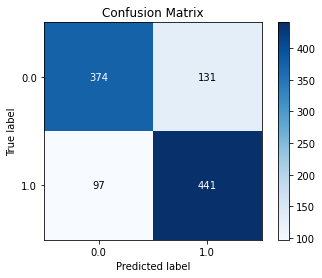

In [55]:
# Confusion Matrix:
skplt.metrics.plot_confusion_matrix(validation_labels,predrmfr)

In [80]:
#print("Score:",round(accuracy_score(validation_labels,predrmfr)*100,2))
#print("Classification Report:",classification_report(validation_labels,predrmfr))

In [69]:
print_score(grid_search, tfidf_train, tfidf_valid, training_labels, validation_labels, train=True)
print("\n******************************\n")
print_score(grid_search, tfidf_train, tfidf_valid, training_labels, validation_labels, train=False)

Train Result:

accuracy score: 0.9994

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1512
         1.0       1.00      1.00      1.00      1614

    accuracy                           1.00      3126
   macro avg       1.00      1.00      1.00      3126
weighted avg       1.00      1.00      1.00      3126


Confusion Matrix: 
 [[1510    2]
 [   0 1614]]

ROC AUC: 0.9993


******************************

Test Result:

accuracy score: 0.7814

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.79      0.74      0.77       505
         1.0       0.77      0.82      0.79       538

    accuracy                           0.78      1043
   macro avg       0.78      0.78      0.78      1043
weighted avg       0.78      0.78      0.78      1043


Confusion Matrix: 
 [[374 131]
 [ 97 441]]

ROC AUC: 0.7801



# Method 4: Logistic Regression Method:

In [75]:
# Fit the Logistic Regression:
from sklearn.linear_model import LogisticRegressionCV

clf = LogisticRegressionCV(cv = 10, scoring = 'accuracy', random_state=2022, n_jobs=-1, verbose=3, max_iter=500).fit(tfidf_train, training_labels)

y_LR_pred = clf.predict(tfidf_valid)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of  10 | elapsed:    6.8s remaining:   15.9s
[Parallel(n_jobs=-1)]: Done   7 out of  10 | elapsed:    7.2s remaining:    3.0s
[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    8.5s finished


<AxesSubplot:title={'center':'Confusion Matrix'}, xlabel='Predicted label', ylabel='True label'>

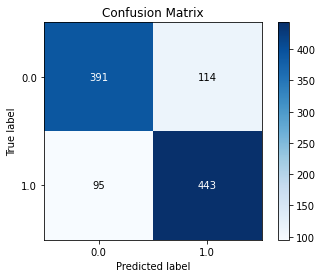

In [76]:
# Confusion Matrix:
skplt.metrics.plot_confusion_matrix(validation_labels, y_LR_pred)

In [79]:
#print("Score:",round(accuracy_score(validation_labels, y_LR_pred)*100,2))
#print("Classification Report:",classification_report(validation_labels, y_LR_pred))

In [78]:
print_score(clf, tfidf_train, tfidf_valid, training_labels, validation_labels, train=True)
print("\n******************************\n")
print_score(clf, tfidf_train, tfidf_valid, training_labels, validation_labels, train=False)

Train Result:

accuracy score: 0.9661

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.96      0.96      1512
         1.0       0.96      0.97      0.97      1614

    accuracy                           0.97      3126
   macro avg       0.97      0.97      0.97      3126
weighted avg       0.97      0.97      0.97      3126


Confusion Matrix: 
 [[1454   58]
 [  48 1566]]

ROC AUC: 0.9660


******************************

Test Result:

accuracy score: 0.7996

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.80      0.77      0.79       505
         1.0       0.80      0.82      0.81       538

    accuracy                           0.80      1043
   macro avg       0.80      0.80      0.80      1043
weighted avg       0.80      0.80      0.80      1043


Confusion Matrix: 
 [[391 114]
 [ 95 443]]

ROC AUC: 0.7988



# Methos 5: Multinomial Naive Bayes:

In [89]:
# Multinomial Naive Bayes
from sklearn.naive_bayes import MultinomialNB

mnb = MultinomialNB()

mnb.fit(tfidf_train, training_labels)

predmnb = mnb.predict(tfidf_valid)

AxesSubplot(0.125,0.125;0.62x0.755)


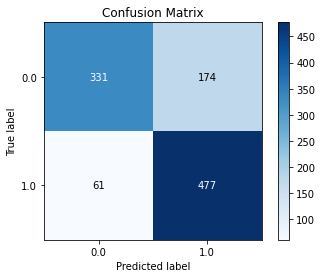

In [90]:
print(skplt.metrics.plot_confusion_matrix(validation_labels, predmnb))

In [93]:
#print("Score:",round(accuracy_score(validation_labels, predmnb)*100,2))
#print("Classification Report:",classification_report(validation_labels, predmnb))

In [92]:
print_score(mnb, tfidf_train, tfidf_valid, training_labels, validation_labels, train=True)
print("\n******************************\n")
print_score(mnb, tfidf_train, tfidf_valid, training_labels, validation_labels, train=False)

Train Result:

accuracy score: 0.9383

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.97      0.90      0.93      1512
         1.0       0.91      0.97      0.94      1614

    accuracy                           0.94      3126
   macro avg       0.94      0.94      0.94      3126
weighted avg       0.94      0.94      0.94      3126


Confusion Matrix: 
 [[1360  152]
 [  41 1573]]

ROC AUC: 0.9370


******************************

Test Result:

accuracy score: 0.7747

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.84      0.66      0.74       505
         1.0       0.73      0.89      0.80       538

    accuracy                           0.77      1043
   macro avg       0.79      0.77      0.77      1043
weighted avg       0.79      0.77      0.77      1043


Confusion Matrix: 
 [[331 174]
 [ 61 477]]

ROC AUC: 0.7710



# Method 6: Support Vector Machines:

In [126]:
from sklearn.svm import SVC

svm = SVC(kernel = 'rbf', random_state = 2022)

Cs = np.logspace(-1,5,5,base = 2)
gammas = np.logspace(-4,5,5,base = 2)
param_grid = dict(C = Cs, gamma = gammas)

In [127]:
grid = GridSearchCV(svm, param_grid = param_grid, cv = 5, scoring='accuracy')

grid.fit(tfidf_train, training_labels)

GridSearchCV(cv=5, estimator=SVC(random_state=2022),
             param_grid={'C': array([ 0.5       ,  1.41421356,  4.        , 11.3137085 , 32.        ]),
                         'gamma': array([ 0.0625    ,  0.29730178,  1.41421356,  6.72717132, 32.        ])},
             scoring='accuracy')

In [128]:
grid.best_score_

0.8039028753993609

In [130]:
grid.best_estimator_.get_params()

{'C': 1.4142135623730951,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 1.4142135623730951,
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 2022,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [131]:
svm1 = SVC(C = 1.4142135623730951,
 break_ties = False,
 cache_size = 200,
 class_weight = None,
 coef0 = 0.0,
 decision_function_shape = 'ovr',
 degree = 3,
 gamma = 1.4142135623730951,
 kernel = 'rbf',
 max_iter = -1,
 probability = False,
 random_state = 2022,
 shrinking = True,
 tol= 0.001,
 verbose= False)
svm1.fit(tfidf_train, training_labels)

predsvm1 = svm1.predict(tfidf_valid)

Confusion Matrix for Support Vector Machine:
AxesSubplot(0.125,0.125;0.62x0.755)


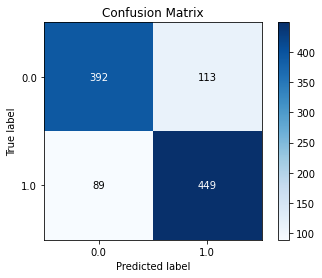

In [132]:
print("Confusion Matrix for Support Vector Machine:")
print(skplt.metrics.plot_confusion_matrix(validation_labels, predsvm1))

In [129]:
print_score(grid, tfidf_train, tfidf_valid, training_labels, validation_labels, train=True)
print("\n******************************\n")
print_score(grid, tfidf_train, tfidf_valid, training_labels, validation_labels, train=False)

Train Result:

accuracy score: 0.9994

Classification Report: 
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      1512
         1.0       1.00      1.00      1.00      1614

    accuracy                           1.00      3126
   macro avg       1.00      1.00      1.00      3126
weighted avg       1.00      1.00      1.00      3126


Confusion Matrix: 
 [[1510    2]
 [   0 1614]]

ROC AUC: 0.9993


******************************

Test Result:

accuracy score: 0.8063

Classification Report: 
               precision    recall  f1-score   support

         0.0       0.81      0.78      0.80       505
         1.0       0.80      0.83      0.82       538

    accuracy                           0.81      1043
   macro avg       0.81      0.81      0.81      1043
weighted avg       0.81      0.81      0.81      1043


Confusion Matrix: 
 [[392 113]
 [ 89 449]]

ROC AUC: 0.8054



# ROC Curve:

In [136]:
from matplotlib.colors import ListedColormap
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, auc 

In [137]:
classifiers = [
    neighbors.KNeighborsClassifier(n_neighbors = 142),
    RandomForestClassifier(bootstrap = True,
 ccp_alpha = 0.0,
 class_weight = None,
 criterion = 'gini',
 max_depth = None,
 max_features = 7,
 max_leaf_nodes = None,
 max_samples = 0.5,
 min_impurity_decrease = 0.0,
 min_impurity_split = None,
 min_samples_leaf = 1,
 min_samples_split = 2,
 min_weight_fraction_leaf = 0.0,
 n_estimators = 100,
 n_jobs = None,
 oob_score = False,
 random_state = 2022,
 verbose = 0,
 warm_start = False),
    MultinomialNB(),
    SVC(C = 1.4142135623730951,
 break_ties = False,
 cache_size = 200,
 class_weight = None,
 coef0 = 0.0,
 decision_function_shape = 'ovr',
 degree = 3,
 gamma = 1.4142135623730951,
 kernel = 'rbf',
 max_iter = -1,
 probability = False,
 random_state = 2022,
 shrinking = True,
 tol= 0.001,
 verbose= False)]

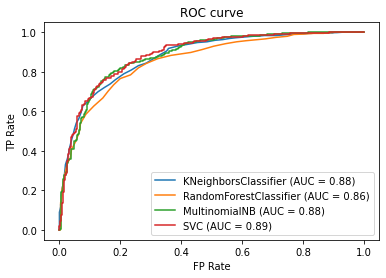

In [138]:
fig, ax = plt.subplots()

model_displays = {}
for clf in classifiers:
    clf.fit(tfidf_train, training_labels)
    name = type(clf).__name__
    model_displays[type(clf).__name__] = plot_roc_curve(
        clf, tfidf_valid, validation_labels, ax=ax, name=name)
plt.legend()
_ = ax.set_title('ROC curve')
_ = ax.set_xlabel('FP Rate')
_ = ax.set_ylabel('TP Rate')